In [2]:
!date

Wed Sep 16 19:38:27 JST 2020


# 読み込むモデルの選択
2020年8月17日

In [3]:
from pathlib import Path
checkpoint = Path('/').joinpath('workspace', 'multirun', '2020-09-06/14-42-49/0')
checkpoint

PosixPath('/workspace/multirun/2020-09-06/14-42-49/0')

# 準備
2020年8月17日

In [4]:
import torch
import pytorch_lightning as pl
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import hydra
import yaml
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 
import numpy as np
from tqdm import tqdm
import sklearn.cluster
from PIL import Image, ImageDraw
import random
import skimage.color
from IPython.display import display

In [5]:
from src.model import Encoder, Decoder
from src.integrated_model import IntegratedModel
from src.patch import make_patch2d

In [6]:
with open(checkpoint.joinpath('.hydra', 'config.yaml')) as file:
    config = hydra.utils.DictConfig(yaml.safe_load(file))
print(config)

{'callback': {'callbacks': None, 'checkpoint': {'class': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'filepath': None, 'mode': 'auto', 'monitor': 'val_loss', 'save_top_k': 1, 'verbose': False}}, 'early_stopping': {'class': 'pytorch_lightning.callbacks.EarlyStopping', 'params': {'min_delta': 0, 'mode': 'auto', 'monitor': 'val_loss', 'patience': '${hparams.early_stopping}', 'verbose': False}}}, 'dataset': {'class': 'src.dataset.adobe_font_char_images', 'params': {'lower': False, 'root': '/dataset/', 'upper': True}}, 'dataset_output_n': 26, 'debug': False, 'experiment_name': 'Default', 'hparams': {'batch_size': 1024, 'dataset_n': 0, 'dataset_n_splits': 5, 'early_stopping': 100, 'latent_dim': 64, 'lr': 0.001, 'max_epochs': 100000, 'min_epochs': 1, 'num_workers': 6, 'patch_size': 15, 'pooling_mode': 'sum', 'seed': 0, 'test_patch_n': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048], 'train_patch_n': [1, 2, 4, 8, 16, 32, 64], 'use_tanh': False, 'valid_patch_n': [1, 2, 4, 8, 1

In [7]:
encoder = Encoder(**config.model_params.encoder)
decoder = Decoder(**config.model_params.decoder)
patch_size = config.hparams.patch_size

In [8]:
cmap26 = np.array([[255,169,166], [64,1,0], [251,0,47], [174,0,26], [99,33,0], [255,113,26], [217,142,0], [255,236,106], [113,111,0], [234,255,193], [149,255,95], [0,75,2], [1,186,170], [1,108,112], [1,196,227], [136,179,255], [1,103,201], [119,101,255], [232,220,255], [74,49,218], [17,0,54], [109,0,167], [218,131,255], [81,0,87], [255,102,225], [17,0,11]]
) / 0xff

In [16]:
characters = 'abcdefghijklmnopqrstuvwxyz'
characters = {c: i for i, c in enumerate(characters)}

In [9]:
import glob

model_checkpoint = glob.glob(str(checkpoint / '**' / '*.ckpt'), recursive=True)
assert len(model_checkpoint) == 1
model_checkpoint = model_checkpoint[0]

In [10]:
transform = torchvision.transforms.Compose([hydra.utils.instantiate(i) for i in config.transform]) if config.transform else None
# target_transform = torchvision.transforms.Compose([hydra.utils.instantiate(i) for i in config.target_transform]) if config.target_transform else None
target_transform = None

____, dataset = hydra.utils.instantiate(config.dataset)
dataset.set_transform(transform, target_transform)

100%|██████████| 4914/4914 [00:00<00:00, 30999.48it/s]


In [11]:
model = IntegratedModel.load_from_checkpoint(model_checkpoint, encoder=encoder, decoder=decoder, optim=None, dataset=dataset)
model

IntegratedModel(
  (encoder): Encoder(
    (fc0): Linear(in_features=225, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc0): Linear(in_features=64, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=26, bias=True)
  )
)

# 白，黒，ランダムの平均，分散，ノルム
2020年8月17日

In [11]:
print('全部0(真っ黒)')
patch = torch.zeros([1, 10000, 1, patch_size, patch_size])
latent = encoder(patch)
print('mean:', latent.mean(1).mean().item())
print(' var:', latent.var(1).mean().item())
print('norm:', latent.norm(1).mean().item())
print()

print('全部1(真っ白)')
patch = torch.ones([1, 10000, 1, patch_size, patch_size])
latent = encoder(patch)
print('mean:', latent.mean(1).mean().item())
print(' var:', latent.var(1).mean().item())
print('norm:', latent.norm(1).mean().item())
print()

print('一様ランダム')
patch = torch.rand([1, 10000, 1, patch_size, patch_size])
latent = encoder(patch)
print('mean:', latent.mean(1).mean().item())
print(' var:', latent.var(1).mean().item())
print('norm:', latent.norm(1).mean().item())
print()

print('01ランダム(ごま塩)')
patch = (torch.rand([1, 10000, 1, patch_size, patch_size]) > 0.5).float()
latent = encoder(patch)
print('mean:', latent.mean(1).mean().item())
print(' var:', latent.var(1).mean().item())
print('norm:', latent.norm(1).mean().item())

全部0(真っ黒)
mean: 0.003501384984701872
 var: 1.49803081017601e-19
norm: 43351.45703125

全部1(真っ白)
mean: 0.011443992145359516
 var: 4.823723594437682e-18
norm: 27635.0625

一様ランダム
mean: -0.006580651272088289
 var: 0.0053473724983632565
norm: 51553.94921875

01ランダム(ごま塩)
mean: -0.0274977870285511
 var: 0.03296416625380516
norm: 115034.6640625


# パッチと分類結果
2020年8月17日

- 文字画像
- パッチ2枚での識別
- パッチ4枚での識別
- パッチ8枚での識別

189.0
0 AGaramondPro-BoldItalic capA


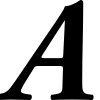


(true_class == predicted_class).item()=False
capA 0.037846148014068604
capI 0.06660513579845428


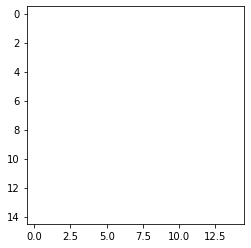

In [12]:
pl.seed_everything(3)
print(len(dataset) / 26)
with torch.no_grad():
    for i, (image, t) in zip(range(1 * 1), dataset):
        font = t['font']
        class_ = t['alphabet']
        print(i, dataset.unique_font[font], dataset.unique_alphabet[class_])
        display(to_pil_image(image))
        print()
        x = image[None].expand([1, -1, -1, -1])
        for patch_n, nrow in zip(*zip([1, 1])):
            patch = make_patch2d(x, config.hparams.patch_size, patch_n)
            y = model(patch)
            max_index = y[:, class_].argmax()

            true_class = class_
            true_prob = y[max_index].softmax(0)[class_].item()
            predicted_class = y[max_index].argmax(0)
            predicted_prob = y[max_index].softmax(0)[predicted_class].item()
            
            print(f'(true_class == predicted_class).item()={(true_class == predicted_class).item()}')
            print(dataset.unique_alphabet[true_class], true_prob)
            print(dataset.unique_alphabet[predicted_class], predicted_prob)
            plt.imshow(to_pil_image(make_grid(patch[max_index], nrow=nrow, pad_value=0.5)))
            plt.show()
            for i in patch[max_index]:
                display(to_pil_image(i))
            print()
        print('='*120)
        print()

189.0
0 AGaramondPro-BoldItalic capA


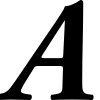


(true_class == predicted_class).item()=True
capA 0.9910895824432373
capA 0.9910895824432373


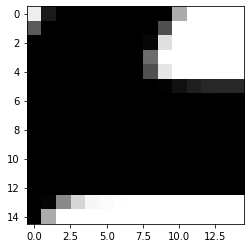


(true_class == predicted_class).item()=True
capA 0.9966865181922913
capA 0.9966865181922913


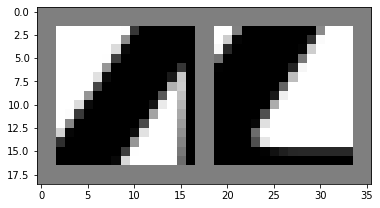


(true_class == predicted_class).item()=True
capA 0.9999957084655762
capA 0.9999957084655762


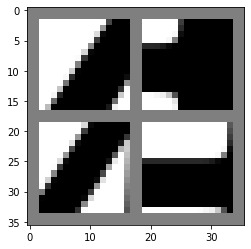


(true_class == predicted_class).item()=True
capA 0.9999996423721313
capA 0.9999996423721313


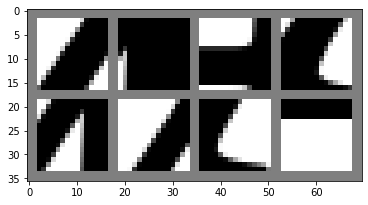

In [14]:
pl.seed_everything(0)
print(len(dataset) / 26)
with torch.no_grad():
    for i, (image, t) in zip(range(1 * 1), dataset):
        font = t['font']
        class_ = t['alphabet']
        print(i, dataset.unique_font[font], dataset.unique_alphabet[class_])
        display(to_pil_image(image))
        print()
        x = image[None].expand([2**18, -1, -1, -1])
        for patch_n, nrow in zip(*zip([1, 1], [2, 2], [4, 2], [8, 4])):
            patch = make_patch2d(x, config.hparams.patch_size, patch_n)
            y = model(patch)
            max_index = y[:, class_].argmax()

            true_class = class_
            true_prob = y[max_index].softmax(0)[class_].item()
            predicted_class = y[max_index].argmax(0)
            predicted_prob = y[max_index].softmax(0)[predicted_class].item()
            
            print(f'(true_class == predicted_class).item()={(true_class == predicted_class).item()}')
            print(dataset.unique_alphabet[true_class], true_prob)
            print(dataset.unique_alphabet[predicted_class], predicted_prob)
            plt.imshow(to_pil_image(make_grid(patch[max_index], nrow=nrow, pad_value=0.5)))
            plt.show()
            for i in patch[max_index]:
                display(to_pil_image(i))
            print()
        print('='*120)
        print()

# パッチのノルム
2020年8月17日

- パッチ画像
- ノルム
- 角度(弧度法)

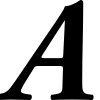

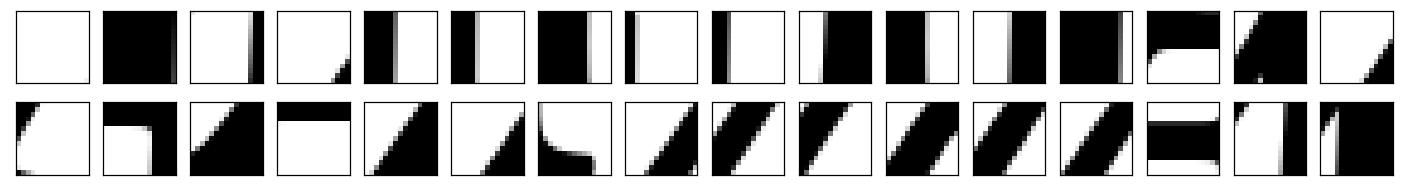

[[[   0.42242    0.88612    1.18754    1.23834    1.24888    1.30805    1.31204    1.40481    1.42342    1.50466    1.51469    1.53857    1.54882    1.84392    1.92496    2.20177]
  [   2.29287    2.33697    2.36981    2.76433    2.89506    2.89688    3.07749    3.15981    3.17888    3.32321    3.42126    3.48017    3.8532     4.14641    4.50109    4.62401]]

 [[ 165.48776 -176.46397  -92.95635  128.73961 -139.59534 -124.36947 -141.26135  -95.79346 -112.01165 -138.99034 -139.86905 -125.33784 -148.12175   80.94002  160.17256  147.89908]
  [  86.82661  162.75136  134.18083   88.29514  142.65376  151.3873  -122.46337  158.646    148.98787  170.7572   154.61378  155.70256  164.87486   57.80636  145.68532  157.55045]]]
[['    I   ' '    H   ' '    H   ' '    Z   ' '    H   ' '    N   ' '    H   ' '    H   ' '    N   ' '    H   ' '    H   ' '    H   ' '    H   ' '    C   ' '    M   ' '    Z   ']
 ['    X   ' '    H   ' '    D   ' '    E   ' '    Z   ' '    Z   ' '    K   ' '    A   ' '    X 

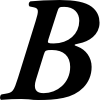

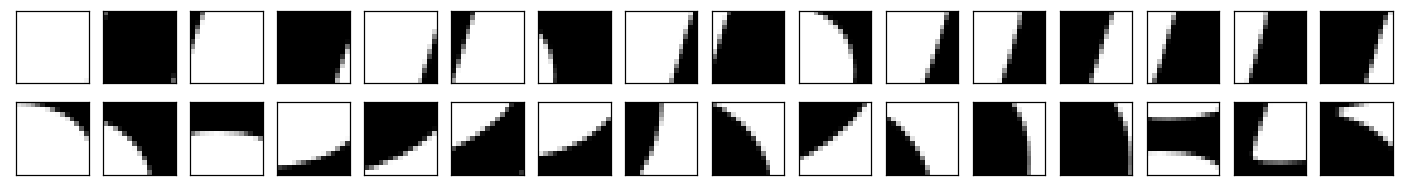

[[[  0.4232    0.65453   0.9547    0.97499   1.17603   1.25966   1.33244   1.33318   1.35901   1.42293   1.43704   1.49246   1.49705   1.55633   1.58987   1.67622]
  [  1.72365   2.0997    2.14176   2.56391   2.81834   2.84005   2.93864   3.01957   3.17501   3.41988   3.59607   3.8332    4.14087   4.44532   4.59298   6.50442]]

 [[165.5118  116.53296 -19.29839 129.71356  78.26447 -78.6413  -77.55889 135.30574 149.82298 -52.67037 129.26253 112.51967 175.70697 128.76164 115.12834 176.62953]
  [-44.93236 -67.93835  63.64556 -45.60799  33.04008   6.68604 -31.74699  62.77217  12.94603  23.15662   3.49711  50.9325   52.29477  -6.02108  32.55073  60.75085]]]
[['    I   ' '    O   ' '    W   ' '    O   ' '    D   ' '    W   ' '    B   ' '    H   ' '    V   ' '    B   ' '    D   ' '    D   ' '    T   ' '    D   ' '    D   ' '    V   ']
 ['    B   ' '    B   ' '    B   ' '    B   ' '    B   ' '    O   ' '    E   ' '    S   ' '    B   ' '    P   ' '    B   ' '    B   ' '    B   ' '    F   ' '    

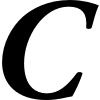

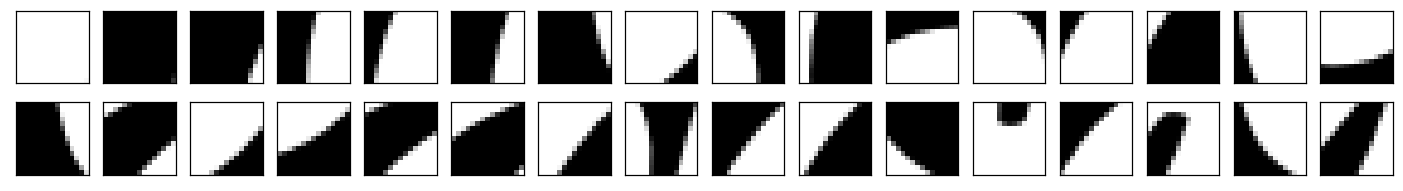

[[[   0.42398    0.56772    0.88969    1.506      1.56036    1.70048    1.70867    1.82904    1.84199    1.85874    1.91867    1.95614    2.21095    2.32847    2.37222    2.38578]
  [   2.44795    2.57077    2.63833    2.76538    2.80628    2.88341    2.93562    2.96739    3.06216    3.12846    3.13756    3.2794     3.58872    3.64282    3.76151    4.15379]]

 [[ 165.53583  101.8213   126.79151 -153.00198  146.05023  179.52982 -175.76746 -163.76576   22.00255   93.37936   76.04607  -74.70343  154.70381  105.33452 -131.80249  -35.21377]
  [-139.18826  115.98055 -156.24275  -30.27641   95.9369    51.05775  122.73449  146.90735  131.98268  122.89233   61.67528  152.29669  142.66508   36.89083  -85.59013  159.63612]]]
[['    I   ' '    B   ' '    O   ' '    O   ' '    O   ' '    O   ' '    O   ' '    Z   ' '    B   ' '    C   ' '    C   ' '    B   ' '    O   ' '    O   ' '    O   ' '    B   ']
 ['    O   ' '    C   ' '    D   ' '    C   ' '    C   ' '    C   ' '    C   ' '    S   ' '    C 

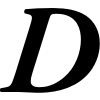

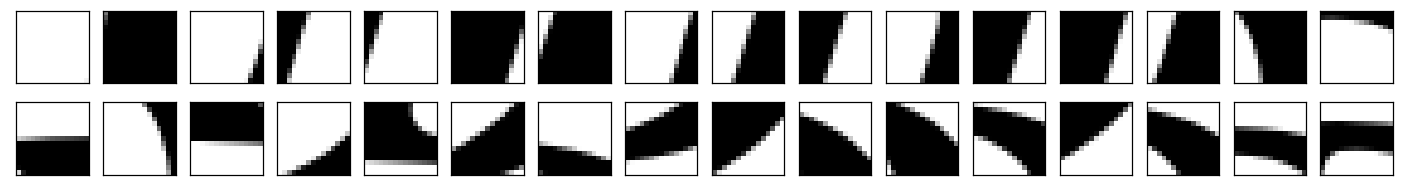

[[[  0.423     0.64052   1.21009   1.22695   1.23329   1.27117   1.27414   1.34574   1.38336   1.4313    1.55632   1.5592    1.64135   1.65227   2.10914   2.1338 ]
  [  2.17144   2.22066   2.37738   2.46891   2.59382   2.80158   2.86422   3.41961   3.44909   3.49546   3.62301   3.63727   3.77564   3.84026   4.09172   4.24656]]

 [[165.50578 130.10245 108.80997 -46.42511 -22.2033  153.83408 148.98347 129.67697 146.04594 175.74242  96.44373 165.64825 167.80386 125.13105  73.90143  46.88906]
  [-80.49851 -78.90865  78.03611 -84.88949  56.82195 -15.6473    9.36012  41.65219  30.18075  12.85354  16.45628 -33.65952  22.77134  -3.32595 -15.1593   31.8834 ]]]
[['    I   ' '    H   ' '    D   ' '    W   ' '    W   ' '    V   ' '    V   ' '    M   ' '    B   ' '    V   ' '    O   ' '    V   ' '    V   ' '    D   ' '    B   ' '    B   ']
 ['    W   ' '    D   ' '    E   ' '    D   ' '    D   ' '    D   ' '    S   ' '    P   ' '    D   ' '    D   ' '    D   ' '    D   ' '    D   ' '    D   ' '    

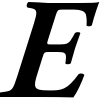

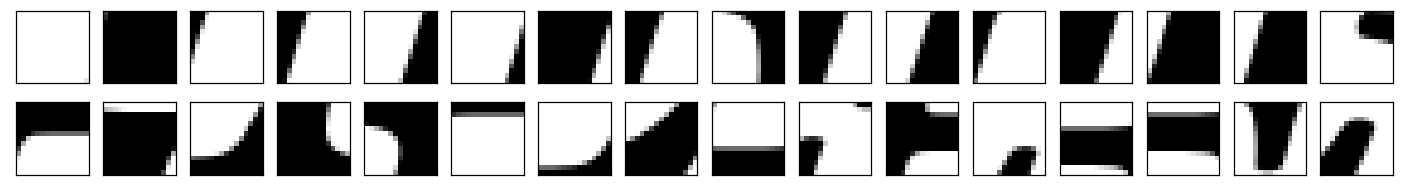

[[[   0.42066    0.55183    1.21819    1.22834    1.27859    1.28239    1.37061    1.38954    1.39675    1.40899    1.41146    1.41355    1.58703    1.61282    1.6132     1.674  ]
  [   1.72651    1.72848    2.06608    2.13989    2.29102    2.50366    2.54507    2.54852    2.68485    3.01779    3.30931    3.88549    4.07388    4.31756    4.94084    5.41872]]

 [[ 165.43367  133.44116  -68.49599  -48.70707  142.4597    98.42965  177.64088  169.16185 -163.02869 -171.47736  142.93271 -115.97581  163.42087  126.59955  123.22224  131.62405]
  [  81.55648 -146.53284 -130.49573   -2.2517  -150.33057   82.03841  -92.81647  102.21335  -15.50012  156.2203    89.24792 -129.63364    4.72252   23.40623  172.21628   37.2522 ]]]
[['    I   ' '    B   ' '    W   ' '    V   ' '    T   ' '    D   ' '    V   ' '    V   ' '    U   ' '    V   ' '    A   ' '    U   ' '    V   ' '    O   ' '    D   ' '    N   ']
 ['    A   ' '    H   ' '    E   ' '    Y   ' '    H   ' '    E   ' '    J   ' '    C   ' '    E 

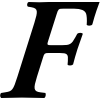

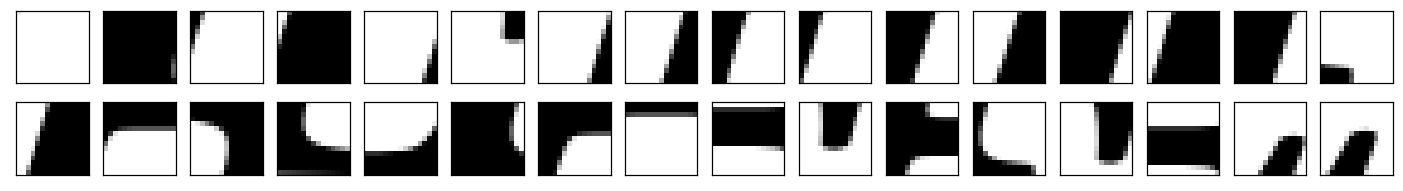

[[[   0.42102    0.94573    0.97553    1.06227    1.09049    1.249      1.2659     1.28059    1.30676    1.36138    1.42108    1.45904    1.46571    1.49282    1.5245     1.56438]
  [   1.57082    1.91828    2.01071    2.07079    2.16454    2.38843    2.50426    2.58526    3.65168    4.00143    4.02369    4.20916    4.6211     4.65376    5.23892    5.2769 ]]

 [[ 165.25598   87.77885  -20.45994  158.32771   87.33477  109.9267   116.23401  140.15898  177.50227  -77.67852 -176.19124  136.27338  176.75632  140.03323  155.81325  -46.96027]
  [ 125.85271   86.88335 -135.51532   56.78772  -96.33344    7.61778   88.13746   83.76034   55.5193   168.95143   82.23565  -64.76961  118.66604   21.95872 -158.19092  -25.87847]]]
[['    I   ' '    B   ' '    W   ' '    M   ' '    A   ' '    T   ' '    A   ' '    M   ' '    W   ' '    W   ' '    V   ' '    A   ' '    V   ' '    A   ' '    V   ' '    M   ']
 ['    D   ' '    A   ' '    H   ' '    A   ' '    E   ' '    B   ' '    A   ' '    E   ' '    E 

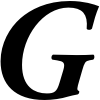

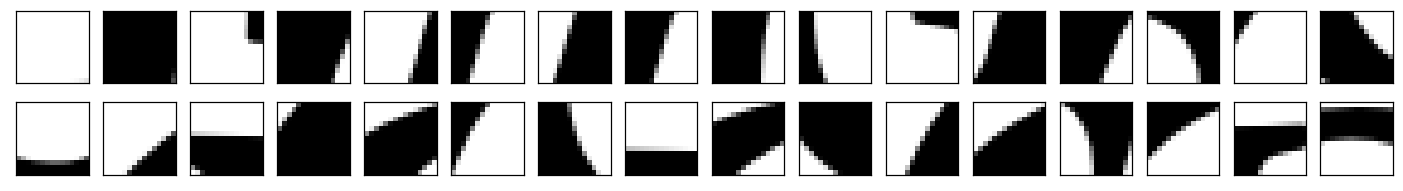

[[[   0.41944    0.65001    1.15483    1.17136    1.26665    1.38116    1.40515    1.43342    1.60802    1.66652    1.73978    1.74182    1.86645    1.88903    1.8933     1.95173]
  [   2.21651    2.39664    2.41763    2.43923    2.4555     2.7069     2.74654    2.80724    2.8131     2.9089     2.97889    3.00096    3.05583    3.42447    3.51851    3.57689]]

 [[ 165.52434  117.91589   99.06664  124.27877  123.36275  179.35127  134.45868 -176.1765  -155.54816 -133.02884   80.80249  114.14481  141.44391  -82.52386   89.62238   25.45426]
  [ -21.20618  121.01252   17.92435  101.57539   53.68001  142.28868 -129.45639    0.97687   64.64806   63.88228  110.85608   65.38422  156.2256   104.005    137.16145   39.58313]]]
[['    I   ' '    H   ' '    W   ' '    O   ' '    H   ' '    H   ' '    D   ' '    H   ' '    O   ' '    O   ' '    F   ' '    O   ' '    O   ' '    B   ' '    Z   ' '    O   ']
 ['    O   ' '    G   ' '    G   ' '    O   ' '    C   ' '    O   ' '    O   ' '    E   ' '    C 

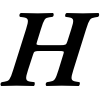

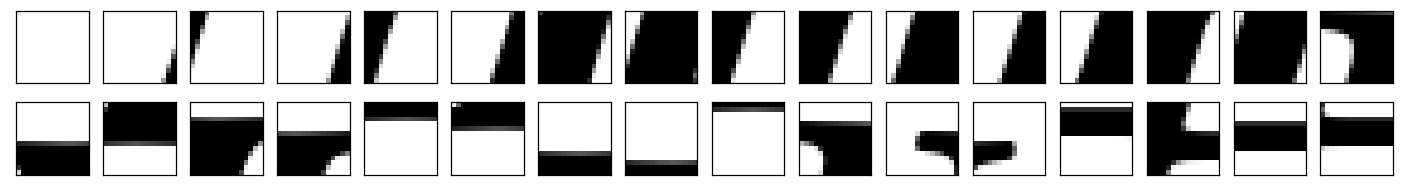

[[[   0.4182     1.03529    1.22815    1.24944    1.26332    1.33853    1.37413    1.41141    1.41845    1.45904    1.48329    1.51913    1.5689     1.70819    1.72711    2.01879]
  [   2.10628    2.18963    2.2991     2.41467    2.49611    2.50551    2.61055    2.65255    2.77818    2.98219    2.99778    3.36781    3.9511     4.01801    5.19352    5.27981]]

 [[ 164.52443  100.62577  -54.60352  118.65063 -163.6258   143.99527  166.37555  131.14928  161.48192 -178.89946  134.78252  155.55634  131.98087  167.13608  135.05989 -142.77985]
  [ -27.24355   89.8755  -179.29958 -156.09966   82.87266   92.86143   -7.69476  -22.11107   76.142   -139.96161   97.19417   55.36115   74.78321  127.59763   41.87062   48.1041 ]]]
[['    I   ' '    B   ' '    W   ' '    A   ' '    V   ' '    T   ' '    F   ' '    A   ' '    V   ' '    H   ' '    A   ' '    T   ' '    D   ' '    G   ' '    D   ' '    H   ']
 ['    W   ' '    H   ' '    G   ' '    H   ' '    E   ' '    H   ' '    E   ' '    E   ' '    F 

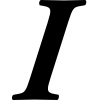

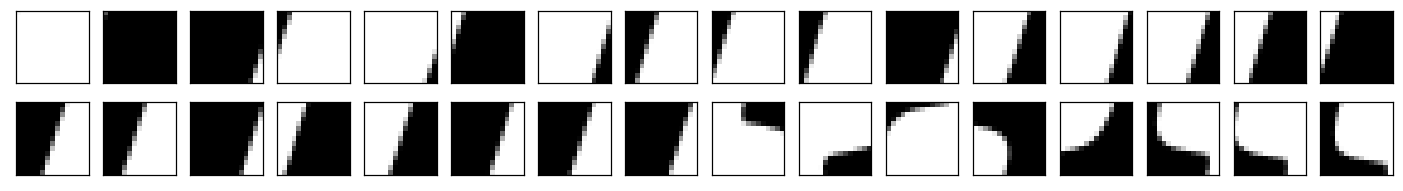

[[[   0.42357    0.57504    0.87672    0.98971    1.00658    1.12582    1.19038    1.22562    1.2337     1.24238    1.26523    1.31029    1.31561    1.3701     1.38933    1.40928]
  [   1.44331    1.44652    1.4578     1.478      1.49721    1.51835    1.52251    1.66757    1.77005    1.93004    2.25291    2.26467    2.46197    2.68193    2.79721    3.82924]]

 [[ 165.4768   109.26284  111.20726  -19.2583   103.93401  152.92087  128.72955 -162.08371  -70.46458  -70.7683   145.51324  134.58412  118.41111  151.49344  142.84238  128.50285]
  [ 176.44812  171.5468   175.55513  133.54846  151.03078  155.57454  176.49406  173.81378  109.81322 -123.49386  -57.45889 -148.92493  126.47771  173.20627 -129.5532   -71.49191]]]
[['    I   ' '    O   ' '    O   ' '    W   ' '    B   ' '    M   ' '    A   ' '    W   ' '    W   ' '    W   ' '    V   ' '    B   ' '    H   ' '    M   ' '    B   ' '    O   ']
 ['    V   ' '    V   ' '    V   ' '    B   ' '    T   ' '    V   ' '    V   ' '    V   ' '    N 

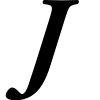

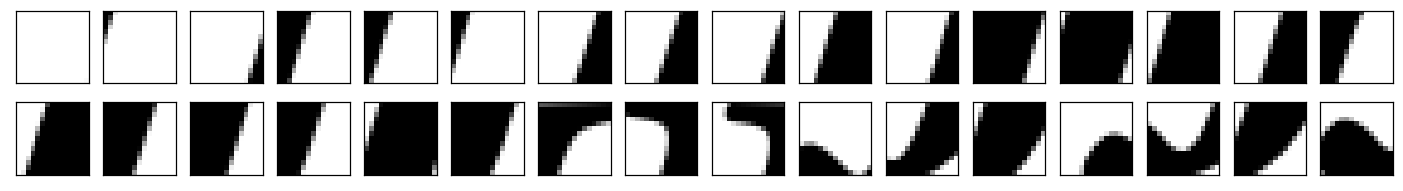

[[[   0.42437    0.74243    1.12753    1.20916    1.21413    1.23089    1.29721    1.33179    1.33972    1.35257    1.36666    1.44593    1.46123    1.46946    1.47247    1.47287]
  [   1.48913    1.50927    1.54376    1.59156    1.67843    1.99661    2.06066    2.28966    2.43575    2.51822    3.26085    3.5834     3.65345    3.91304    4.23894    4.36177]]

 [[ 165.54729   24.72192   83.8489   157.61473  -10.86766  -43.68032  138.68622  143.30403  127.79914  144.944    140.96867  175.59093  126.05054  139.14584  152.40005  165.12244]
  [ 133.43198  142.17671  160.5015   117.20452  144.15648  107.78629   19.14223 -144.85596 -166.03256   53.04734   43.38915   73.42005   76.45314   76.38778   44.23269   55.94808]]]
[['    I   ' '    W   ' '    D   ' '    V   ' '    V   ' '    W   ' '    A   ' '    A   ' '    A   ' '    B   ' '    H   ' '    V   ' '    V   ' '    A   ' '    T   ' '    G   ']
 ['    B   ' '    V   ' '    V   ' '    V   ' '    V   ' '    O   ' '    U   ' '    N   ' '    H 

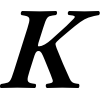

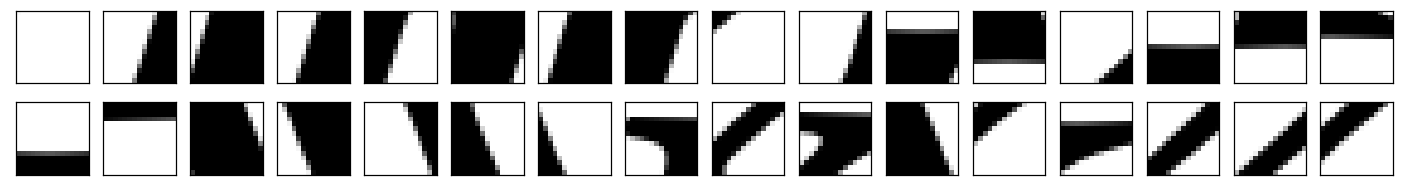

[[[   0.42413    1.30822    1.35029    1.415      1.44256    1.44827    1.50988    1.5753     1.62649    1.6305     1.80044    1.82176    1.82673    2.32488    2.43662    2.47646]
  [   2.62255    2.62987    2.68691    2.77294    2.84614    2.95166    2.95485    3.0335     3.2059     3.24935    3.38648    3.42685    3.94195    4.58216    4.67526    4.79269]]

 [[ 165.51509  150.6453   136.08595  143.79254  168.0496    97.65113  133.53288  173.68884  -18.12447  118.43219   83.93611   87.76553  150.80402  -11.06912   89.28237  100.2915 ]
  [  -8.79416   81.80054  161.3819  -155.7564  -126.1974  -154.10655  169.78076 -134.7846   125.74283   85.1279  -165.0005   105.99624   73.41805  154.47444  170.40268  124.01413]]]
[['    I   ' '    B   ' '    A   ' '    A   ' '    V   ' '    O   ' '    B   ' '    H   ' '    K   ' '    D   ' '    G   ' '    H   ' '    K   ' '    E   ' '    M   ' '    M   ']
 ['    E   ' '    E   ' '    A   ' '    V   ' '    V   ' '    V   ' '    A   ' '    H   ' '    K 

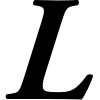

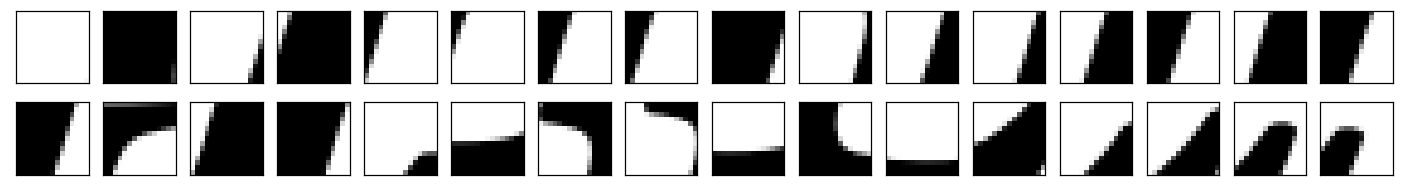

[[[   0.42359    0.74471    1.09252    1.18062    1.20237    1.20902    1.21502    1.2351     1.26384    1.30835    1.33723    1.3404     1.39409    1.40927    1.4123     1.43245]
  [   1.51306    1.51837    1.57792    1.59216    1.85482    2.01769    2.02447    2.08497    2.2488     2.30092    2.50718    2.67159    2.70102    4.1231     4.99747    5.21228]]

 [[ 165.52382  175.01404   91.11549  157.14838  -69.66122   -0.41242  153.55017  -86.31859  146.41028  106.82529  131.91644  148.15369  144.84729  170.06233  140.91492 -174.76698]
  [ 155.91096  -44.17819  134.03807 -176.36145  120.10863  -22.1951  -146.09859  166.56276  -24.73255    3.80095  -31.75385   55.09004  147.09445  173.54103   37.8123    68.82465]]]
[['    I   ' '    H   ' '    D   ' '    M   ' '    W   ' '    V   ' '    V   ' '    V   ' '    V   ' '    D   ' '    A   ' '    H   ' '    B   ' '    V   ' '    B   ' '    V   ']
 ['    V   ' '    B   ' '    B   ' '    V   ' '    M   ' '    B   ' '    N   ' '    H   ' '    E 

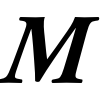

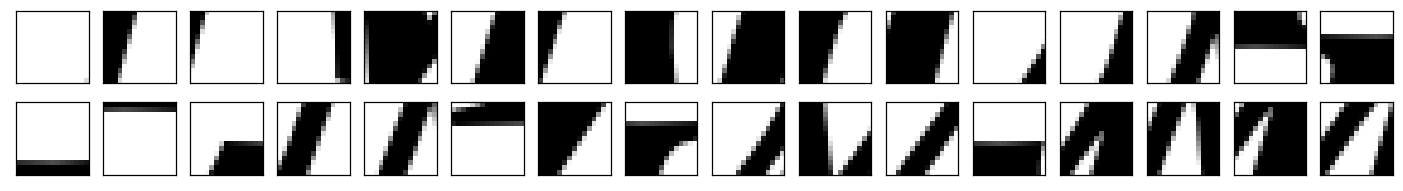

[[[   0.41852    1.16035    1.20676    1.23709    1.35229    1.36921    1.39889    1.40227    1.42878    1.51255    1.60825    1.65641    1.67428    2.13522    2.2615     2.44094]
  [   2.63226    2.72375    2.83456    2.83594    2.95118    2.9527     3.04456    3.15077    3.86516    4.21508    4.75545    4.90842    6.05343    7.17848    8.90339   10.39241]]

 [[ 165.36761   31.79326  -47.74815  157.37971  130.35693  146.90907  -84.71295 -137.12396  139.93282  151.59102  169.80957  137.87645  109.07657  152.90903  108.08556 -117.84911]
  [ -30.03804   77.26613  123.62315  166.29129  170.12962  105.00881  165.55278 -169.96504  170.90361  128.83179  169.34668   63.0314   163.98973  163.63481  166.09619  162.58371]]]
[['    I   ' '    W   ' '    U   ' '    W   ' '    W   ' '    B   ' '    V   ' '    G   ' '    T   ' '    G   ' '    H   ' '    Z   ' '    D   ' '    A   ' '    M   ' '    G   ']
 ['    E   ' '    F   ' '    M   ' '    M   ' '    A   ' '    H   ' '    Z   ' '    H   ' '    A 

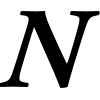

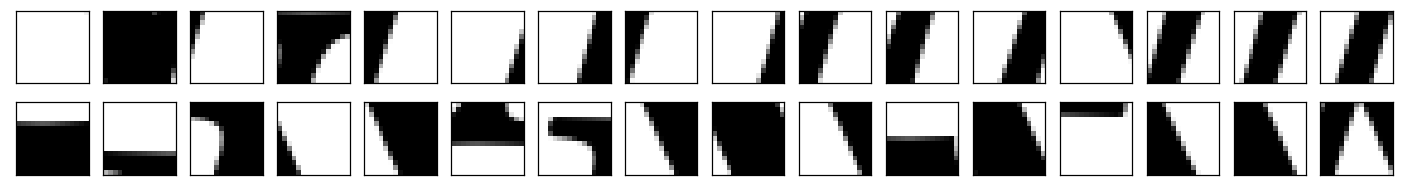

[[[   0.42163    0.80926    1.03071    1.16925    1.24492    1.24653    1.29193    1.32948    1.35289    1.69684    1.86748    2.02054    2.17273    2.18128    2.21157    2.24817]
  [   2.28487    2.31233    2.50151    2.52063    2.73868    2.76114    2.9598     3.09489    3.15815    3.18741    3.26712    3.2814     3.48824    3.60515    3.69804    7.49489]]

 [[ 165.24442  125.68377  -31.53021 -115.47376 -155.9686   101.06622  153.418    -78.5194   104.6047   179.7525   160.65471  150.51237 -130.72037  172.77116  163.66013 -178.98428]
  [  30.36102  -58.00908 -148.41016  165.29343 -159.98459  102.81644 -171.00642 -146.06412   87.56742 -142.74805   38.99947  166.24738   83.52436 -158.68831 -162.06406 -172.75491]]]
[['    I   ' '    W   ' '    U   ' '    U   ' '    V   ' '    D   ' '    H   ' '    U   ' '    D   ' '    W   ' '    N   ' '    M   ' '    Y   ' '    W   ' '    N   ' '    N   ']
 ['    E   ' '    W   ' '    H   ' '    N   ' '    V   ' '    M   ' '    W   ' '    V   ' '    V 

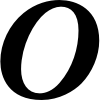

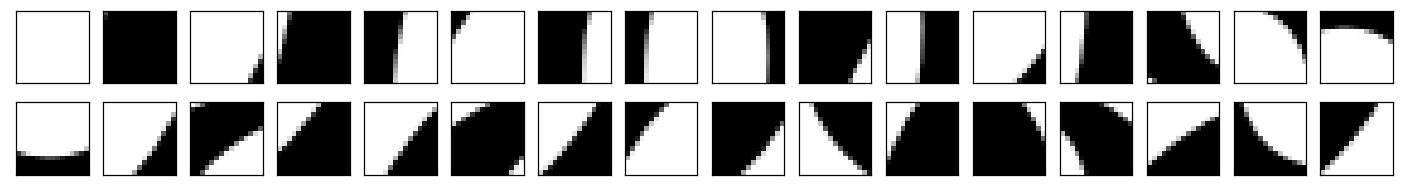

[[[   0.42329    0.54932    1.08507    1.37293    1.40261    1.43286    1.57245    1.59305    1.66957    1.74598    1.86474    1.87754    1.92158    2.02613    2.11239    2.17148]
  [   2.46302    2.57575    2.61596    2.6618     2.88996    2.89748    3.03084    3.09907    3.127      3.14267    3.23191    3.2453     3.27337    3.31267    3.56604    3.74696]]

 [[ 165.4577   119.51505  116.6958   136.7405  -145.05617   77.72238 -143.39294 -135.71344   77.26781  125.97205  131.67247  171.4728   108.95895  -20.82988  -73.84276   50.50998]
  [ -20.65204  156.78069   77.21149  132.26816  124.81688   86.14676  147.133    140.41614   82.82925   48.10416  118.30907   37.69235   13.27847   79.45029  -18.74877   72.55486]]]
[['    I   ' '    B   ' '    A   ' '    D   ' '    G   ' '    Z   ' '    O   ' '    Q   ' '    Q   ' '    Z   ' '    O   ' '    O   ' '    O   ' '    S   ' '    S   ' '    C   ']
 ['    Q   ' '    Z   ' '    C   ' '    Z   ' '    C   ' '    O   ' '    X   ' '    O   ' '    O 

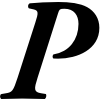

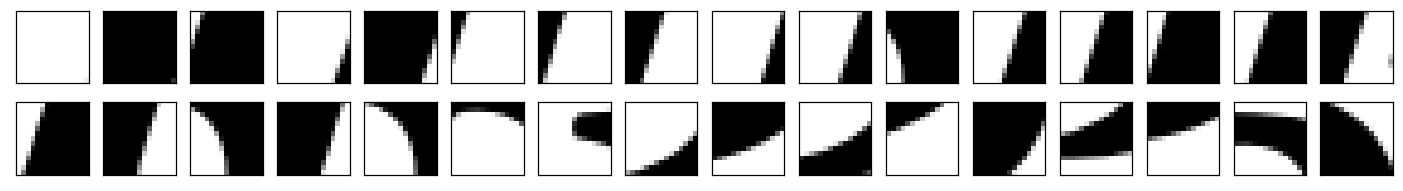

[[[   0.42183    0.57642    1.07124    1.14298    1.18713    1.18849    1.27463    1.3544     1.35852    1.37934    1.39022    1.39266    1.42626    1.4408     1.44107    1.44467]
  [   1.49961    1.50004    1.61594    1.65474    1.73346    2.02823    2.14889    2.63703    2.78121    2.91653    3.35713    3.39882    3.61221    3.76484    3.82494    4.17078]]

 [[ 165.46973   88.98987  156.96785  103.09334  143.23558  -56.24539  -69.9085   149.62804  123.69341  150.6592   -66.53191  155.72516  143.65866  133.56076  140.00722  170.16138]
  [ 133.63191  171.33427  -79.27081  169.31746  -82.81871   18.73403  108.81934  -66.43305   50.81894  -39.39754   19.2005    49.89444   33.1902    56.16692 -101.97911   18.66068]]]
[['    I   ' '    B   ' '    M   ' '    D   ' '    V   ' '    V   ' '    V   ' '    V   ' '    A   ' '    M   ' '    B   ' '    T   ' '    A   ' '    D   ' '    B   ' '    V   ']
 ['    A   ' '    G   ' '    B   ' '    V   ' '    B   ' '    S   ' '    G   ' '    D   ' '    P 

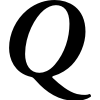

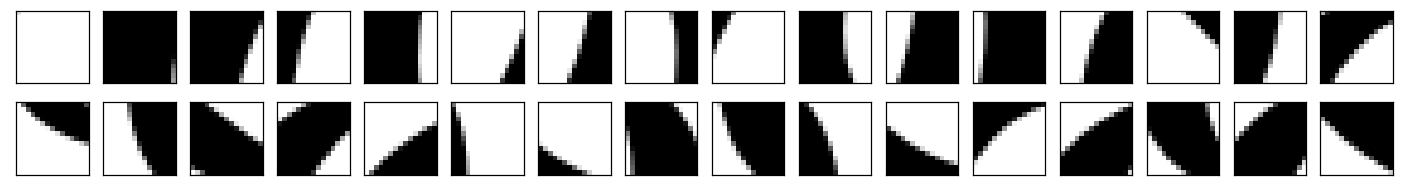

[[[   0.41631    1.03886    1.33784    1.4491     1.65736    1.71003    1.72628    1.84591    1.85093    1.90774    1.94074    1.95593    2.20114    2.23688    2.32121    2.37729]
  [   2.60706    2.7438     2.80335    2.97166    2.99145    3.01102    3.01969    3.14297    3.26522    3.28785    3.33045    3.33489    3.56582    3.60184    4.00099    4.56706]]

 [[ 164.0138   176.88696  147.72704  172.16937 -141.7388   130.04999   97.65312   93.75967  155.76529 -145.80975   94.57349  115.67382   90.48638   45.67889   67.89418   84.60106]
  [  63.13618   67.60022   44.57777  113.55215  120.73318   50.65599  -48.34882   45.54337   62.02057   35.54546   16.58415  108.84049   67.09541   60.4818    98.17715   61.41233]]]
[['    I   ' '    H   ' '    O   ' '    G   ' '    Q   ' '    O   ' '    O   ' '    Q   ' '    O   ' '    Q   ' '    O   ' '    O   ' '    Q   ' '    K   ' '    Q   ' '    Q   ']
 ['    Q   ' '    S   ' '    Q   ' '    G   ' '    G   ' '    Q   ' '    S   ' '    Q   ' '    S 

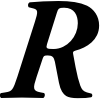

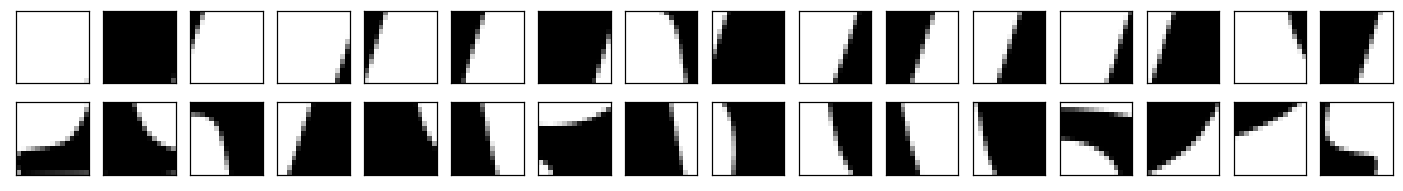

[[[   0.41968    0.61673    0.96061    1.09625    1.20854    1.21229    1.24717    1.27962    1.31382    1.38443    1.43655    1.44687    1.47453    1.47951    1.48597    1.51307]
  [   1.57369    1.63612    1.64015    1.65034    1.80241    2.19189    2.2865     2.29073    2.4503     2.54651    2.56203    2.57783    2.89552    3.16797    3.49724    3.89133]]

 [[ 165.40366   78.12092   -4.41238   86.43729  -66.71132 -146.45667  149.59833 -105.92802  148.37314  127.09741  174.6521   144.18614  120.26987  139.40314   61.99378  156.0522 ]
  [-131.98999   33.95612 -157.02696  128.83904  145.7042  -165.20445   47.42177 -170.08545   66.17733   74.57207 -161.00548  141.8646  -105.30239   36.77137   21.1521  -120.91222]]]
[['    I   ' '    B   ' '    V   ' '    A   ' '    W   ' '    H   ' '    V   ' '    D   ' '    V   ' '    A   ' '    V   ' '    T   ' '    A   ' '    A   ' '    U   ' '    V   ']
 ['    H   ' '    S   ' '    A   ' '    D   ' '    O   ' '    W   ' '    Q   ' '    W   ' '    B 

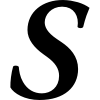

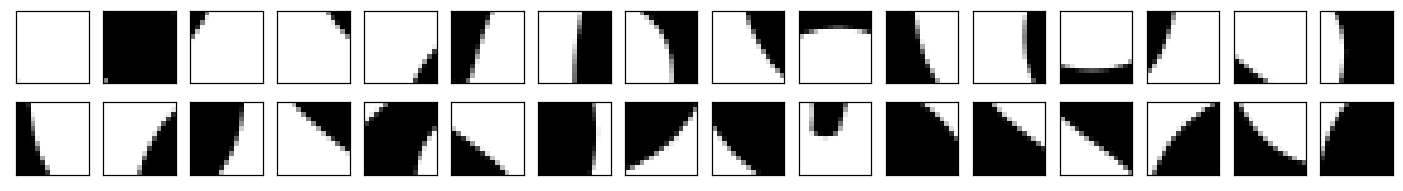

[[[   0.4223     0.90637    1.10531    1.21129    1.23384    1.34753    1.65227    1.89478    2.25995    2.32959    2.33341    2.41511    2.45758    2.49291    2.54394    2.60091]
  [   2.65857    2.80333    3.03134    3.04456    3.07496    3.16907    3.22483    3.27355    3.31792    3.39095    3.44833    3.54551    3.60455    3.6638     3.71531    4.07785]]

 [[ 165.25989   73.76012   17.85906   71.02132  111.92918  167.83234   85.88572  -19.17344   48.04023   55.9652  -139.59393   61.96475  -23.9157    50.43919  -38.2658    64.18088]
  [-149.07704   85.76006   65.47551   52.1593    97.94981   -2.43381   62.03685   36.85658   59.40778  161.38449   32.95195   48.93803   61.65011   92.42476   -0.34876   97.74299]]]
[['    I   ' '    X   ' '    Q   ' '    C   ' '    Q   ' '    V   ' '    C   ' '    B   ' '    S   ' '    S   ' '    C   ' '    S   ' '    Q   ' '    B   ' '    S   ' '    B   ']
 ['    O   ' '    S   ' '    S   ' '    O   ' '    S   ' '    D   ' '    B   ' '    P   ' '    C 

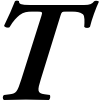

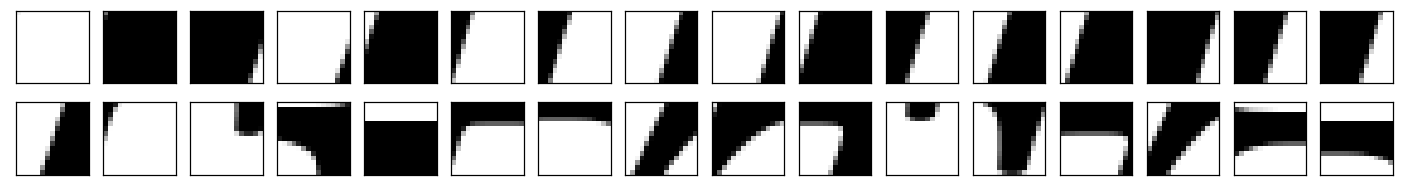

[[[   0.42132    0.59386    1.08311    1.11143    1.14882    1.19983    1.22596    1.28668    1.35498    1.36512    1.40381    1.41208    1.47765    1.48013    1.50338    1.5246 ]
  [   1.53066    1.56974    1.63662    2.00445    2.29319    2.40362    2.45848    2.59082    2.85276    2.95011    3.2297     3.29938    3.43886    3.86665    3.93108    4.63296]]

 [[ 165.3062   110.05379  116.44915   99.75229  153.0476   -71.24197 -139.51558  142.34491  130.03366  134.97131  166.66524  141.17587  137.49968  179.80498  179.98572  157.00958]
  [ 143.9436    85.97945   81.05249  152.27081   47.72592  126.33705   77.15186  138.13287   95.19672  171.64285  172.94025 -177.31848  135.88887  133.41978   65.21197   25.3486 ]]]
[['    I   ' '    Z   ' '    O   ' '    D   ' '    M   ' '    W   ' '    W   ' '    B   ' '    A   ' '    A   ' '    V   ' '    B   ' '    A   ' '    V   ' '    T   ' '    V   ']
 ['    T   ' '    O   ' '    T   ' '    F   ' '    E   ' '    A   ' '    B   ' '    Z   ' '    C 

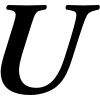

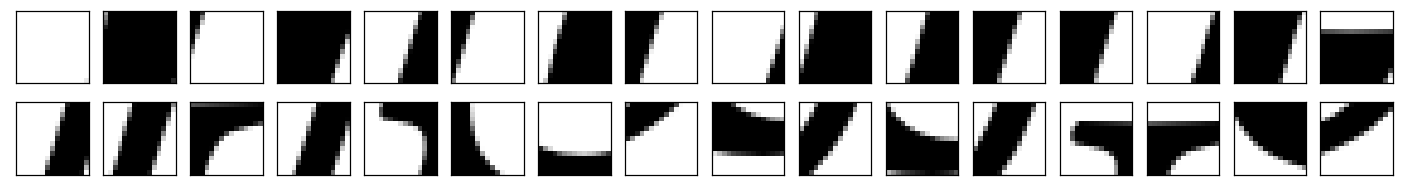

[[[   0.42105    0.78627    0.99137    1.17215    1.26872    1.30267    1.32289    1.32892    1.38211    1.40952    1.41923    1.43667    1.48506    1.54242    1.63546    1.73638]
  [   1.80267    1.88984    1.89461    1.97832    2.19801    2.2665     2.40745    2.84496    3.31407    3.34087    3.41406    3.50742    3.63422    3.65642    4.6529     4.9241 ]]

 [[ 165.4457   125.16276  -20.11698  130.16212  141.99197  -78.07903  112.03469  145.25511  114.22042  126.7166   132.01952  175.79846  173.40678  121.39185  174.29744   60.76612]
  [ 136.72545  155.14139   25.26381  151.04887 -175.7485   -47.38924   -3.29572    8.27302   63.71594   87.7346    27.36858  100.97988  178.63629  142.40321   61.90889   26.02718]]]
[['    I   ' '    D   ' '    W   ' '    O   ' '    T   ' '    W   ' '    O   ' '    V   ' '    D   ' '    D   ' '    D   ' '    V   ' '    H   ' '    D   ' '    V   ' '    G   ']
 ['    M   ' '    W   ' '    S   ' '    M   ' '    H   ' '    S   ' '    U   ' '    P   ' '    Q 

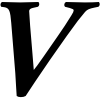

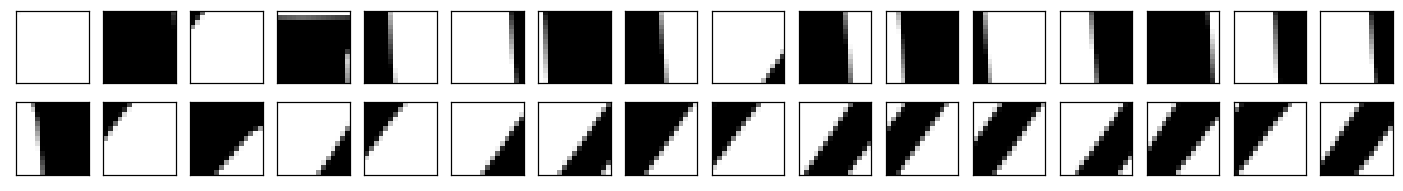

[[[   0.42357    0.67894    0.91078    1.31627    1.44815    1.45098    1.46119    1.46805    1.53809    1.62968    1.65065    1.65122    1.70082    1.70488    1.81885    1.83247]
  [   1.91369    2.17885    2.4223     2.52223    2.83631    2.87839    3.14246    3.26985    3.27446    3.52132    3.54219    3.56284    3.64508    3.73517    3.81173    3.88284]]

 [[ 165.4768   108.05035   41.01954 -155.08392 -165.13704 -144.69972 -157.33397 -168.60324  138.31427 -177.46185 -169.67247  171.5573  -157.19101 -166.63824 -145.14772 -146.76256]
  [-168.33054  122.32348  146.04001  154.52293  144.62689  152.055    160.89127  164.07594  157.30147  165.5003   158.30948  151.29016  149.89041  151.72481  169.745    133.0472 ]]]
[['    I   ' '    V   ' '    Z   ' '    G   ' '    M   ' '    V   ' '    W   ' '    M   ' '    Z   ' '    M   ' '    W   ' '    A   ' '    W   ' '    M   ' '    V   ' '    V   ']
 ['    D   ' '    Z   ' '    C   ' '    Z   ' '    Z   ' '    Z   ' '    X   ' '    Z   ' '    Z 

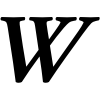

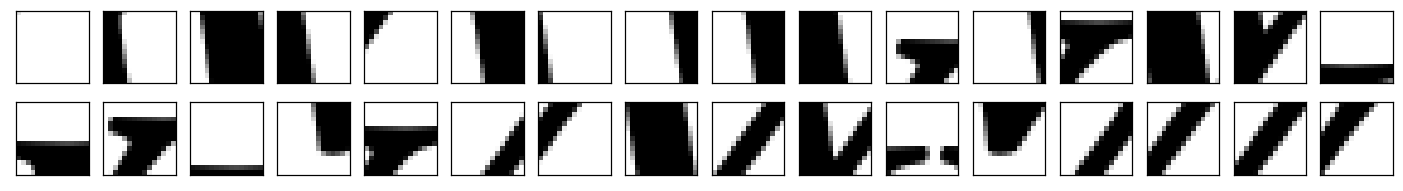

[[[   0.41631    0.98218    1.71012    1.89868    1.98768    2.01781    2.06061    2.06957    2.08024    2.08874    2.13521    2.174      2.18567    2.31641    2.45232    2.53706]
  [   2.73762    2.75709    2.78184    2.78323    2.95803    3.35685    3.40854    3.60602    3.99377    4.05829    4.14595    4.34645    4.45733    4.46276    4.51094    4.90015]]

 [[ 164.0138  -134.63786  162.0493  -176.75475  127.13689 -155.33861  168.23894 -149.87032 -161.31976 -171.62895 -117.93144 -146.39958  104.66325 -170.88916  145.37921  -15.08973]
  [ -79.47254 -169.37794  -38.37066   75.35708  -94.30695  164.0726   161.31097 -175.62427  175.6357   139.69087   26.33724  109.461    174.23358  162.83325  166.00931  165.44614]]]
[['    I   ' '    Q   ' '    W   ' '    W   ' '    Z   ' '    V   ' '    A   ' '    V   ' '    V   ' '    A   ' '    W   ' '    V   ' '    K   ' '    W   ' '    W   ' '    W   ']
 ['    W   ' '    W   ' '    E   ' '    W   ' '    H   ' '    A   ' '    Y   ' '    V   ' '    X 

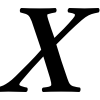

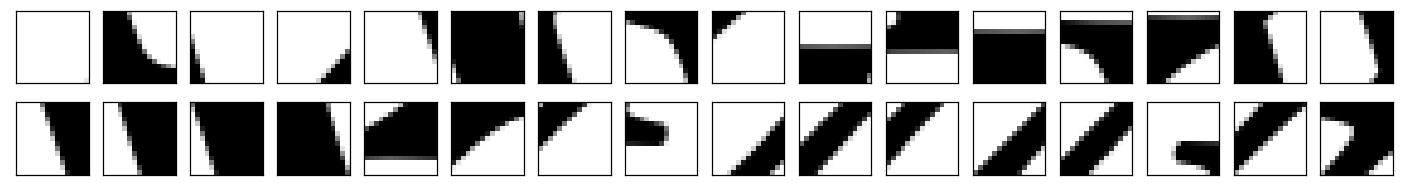

[[[   0.42046    1.86906    1.91544    1.92185    1.96494    1.98205    2.03527    2.05815    2.07545    2.168      2.3095     2.37065    2.41567    2.49252    2.62074    2.66457]
  [   2.72547    2.72549    2.75793    2.78692    2.89828    3.39656    3.42693    3.53778    3.5708     3.97529    4.11267    4.5108     4.5693     4.83468    4.89545    5.72292]]

 [[ 165.42767    1.89582  156.76941  155.98871 -134.80313  159.70169 -158.42181 -131.69995   10.03999  -37.53975  103.90348   31.17366 -113.04766   71.61459  -69.17688  128.5887 ]
  [-150.70726 -149.90074 -168.41278 -157.28584  103.39182  114.02713  127.83485  118.30663 -177.1785   153.11668  157.85098  167.46008  161.01924   50.63472  150.66093  168.72154]]]
[['    I   ' '    A   ' '    A   ' '    Z   ' '    V   ' '    V   ' '    W   ' '    V   ' '    K   ' '    W   ' '    M   ' '    E   ' '    N   ' '    X   ' '    X   ' '    X   ']
 ['    V   ' '    V   ' '    V   ' '    V   ' '    X   ' '    C   ' '    K   ' '    H   ' '    K 

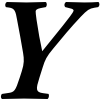

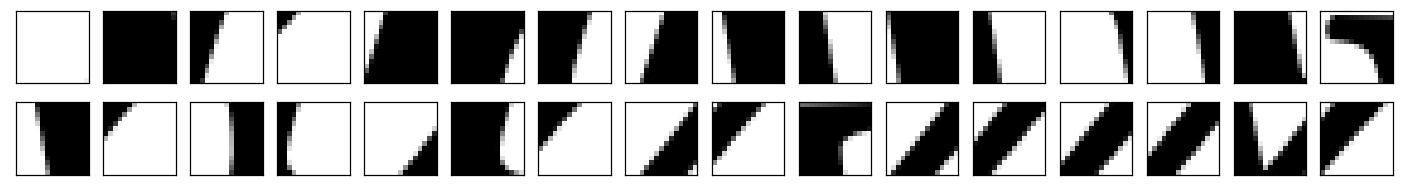

[[[   0.42281    0.69049    1.25194    1.29934    1.42019    1.48737    1.51741    1.52109    1.81311    1.89484    1.93919    1.93968    1.95829    2.13111    2.14612    2.17672]
  [   2.19184    2.21263    2.34429    2.45076    2.86128    2.94636    3.00848    3.32552    3.73055    3.78282    3.7862     3.80669    3.84094    4.10044    5.00246    5.04563]]

 [[ 165.49977   99.03472  171.72006  -16.51864  129.05774  130.10158 -166.4314   134.98155 -172.24725 -175.93654  157.37029  172.31593 -114.04273 -145.22289 -151.82771 -148.06314]
  [-154.15923  112.20561   83.09951  -55.98724  159.90837   18.21506  143.68098  160.85304  167.98483  -16.89815  166.7684   151.64131  155.78363  157.42648  122.84593  149.99062]]]
[['    I   ' '    V   ' '    V   ' '    Z   ' '    O   ' '    G   ' '    G   ' '    D   ' '    W   ' '    A   ' '    O   ' '    W   ' '    O   ' '    V   ' '    W   ' '    N   ']
 ['    V   ' '    Z   ' '    B   ' '    H   ' '    Z   ' '    A   ' '    Z   ' '    Z   ' '    X 

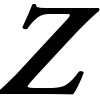

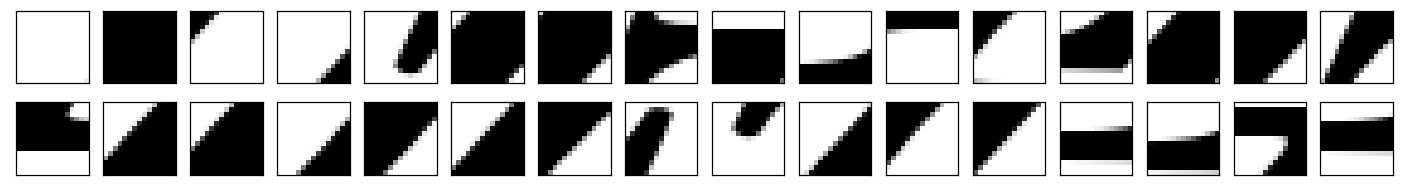

[[[   0.42164    0.64991    1.87562    1.91715    1.98261    2.05711    2.10432    2.18314    2.19781    2.38604    2.39304    2.54639    2.66633    2.74588    2.83623    3.02164]
  [   3.16926    3.21022    3.26639    3.40222    3.46532    3.46713    3.49832    3.5099     3.70265    3.89261    3.9463     4.29108    4.30945    4.4945     4.79913    5.17988]]

 [[ 165.46373 -177.4978    34.95557  148.43372 -101.06311   92.98286  116.7901    97.94659   49.57113  -33.10612   85.72891  130.7191    56.14777  108.63607  158.66971  136.18605]
  [  97.69632  125.53899  119.27843  156.22551  138.54247  143.28769  139.84845  -45.22209  120.68826  156.81198  161.30312 -179.62108    2.13162  -12.80431  143.22182   28.29742]]]
[['    I   ' '    B   ' '    Z   ' '    Z   ' '    Z   ' '    Z   ' '    Z   ' '    T   ' '    E   ' '    B   ' '    E   ' '    X   ' '    P   ' '    Z   ' '    Z   ' '    Z   ']
 ['    M   ' '    Z   ' '    Z   ' '    Z   ' '    Z   ' '    Z   ' '    Z   ' '    Z   ' '    Z 

In [44]:
with torch.no_grad():
    for i in range(26 * 1):
        pl.seed_everything(0)
        
        x = dataset[i][0][None]
        display(to_pil_image(x[0]))
        patch_list = make_patch2d(x, config.hparams.patch_size, 2**10)[0]
        
        km = sklearn.cluster.KMeans(32)
        centroid_index = km.fit_transform(patch_list.reshape(len(patch_list), -1)).argmin(0)
        patch_list = patch_list[centroid_index]
        
        latent = encoder(patch_list)
        index = latent.norm(dim=[1, 2]).argsort()

        patch_list = patch_list[index]
        latent = latent[index]

        fig, ax_list = plt.subplots(2, 16, figsize=[16, 2], dpi=111)
        for ax, patch in zip(ax_list.flatten(), patch_list):
            pil_im = to_pil_image(patch)
            display(pil_im)
            ax.imshow(pil_im, 'gray', vmin=0, vmax=0xff)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()

        tmp = np.get_printoptions()
        np.set_printoptions(precision=5, suppress=True, linewidth=np.inf)
        print(torch.stack([
    #         latent[:, 0, 0],
    #         latent[:, 0, 1],
            latent.norm(dim=[1, 2]),
            torch.atan2(latent[:, 0, 1], latent[:, 0, 0]) * 180 / np.pi,
        ]).numpy().reshape(-1, 2, 16))
        print(np.array([f'    {i[3:]}   ' for i in dataset.unique_alphabet])[decoder(latent[:, 0]).argmax(1)].reshape(2, 16))
        np.set_printoptions(**tmp)

# パッチの分布可視化
2020年8月17日

- 文字画像
- 空間上に並べられたパッチ

In [ ]:
print(len(dataset) / 26)
zoom = 1

with torch.no_grad():
    for i, (image, t) in zip(range(26 * 1), dataset):
        font = t['font']
        class_ = t['alphabet']
        print(i, dataset.unique_font[font], dataset.unique_alphabet[class_])
        plt.imshow(to_pil_image(image), 'gray', vmin=0, vmax=0xff)
        plt.show()
        x = image[None].expand([1, -1, -1, -1])
        
        pl.seed_everything(0)
        
        patch = make_patch2d(x, config.hparams.patch_size, 2**10)
        y = encoder(patch)
        
#         km = sklearn.cluster.KMeans(16)
#         centroid_index = km.fit_transform(y[0]).argmin(0)
        
        fig, ax = plt.subplots(figsize=[4, 4], dpi=100)
#         for coord, image in zip(y[0, centroid_index], patch[0, centroid_index]):
        for coord, image in zip(y[0], patch[0]):
            image = to_pil_image(image.expand(3, -1, -1))
            image = OffsetImage(image, zoom=zoom)
            ab = AnnotationBbox(image, coord, xycoords='data', frameon=True, pad=0.2)
            ax.add_artist(ab)
        lim = y.abs().max() * 1.2
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        plt.show()

# 合成ベクトルと分類マップの可視化
2020年8月17日

- パッチの切り出し元
- 合成ベクトル
- 合成ベクトルと識別マップのオーバーレイ
- パッチの特徴量(x,y,ノルム,角度)

In [45]:
# s = 0.4
# markerscale = 15
# with torch.no_grad():
#     for i, (image, t) in zip(range(26), dataset):
#         pl.seed_everything(0)
        
#         font = t['font']
#         class_ = t['alphabet']
#         print(i, dataset.unique_font[font], dataset.unique_alphabet[class_])
#         pil_image = to_pil_image(image.expand(3, -1, -1))

# #         fig, ax = plt.subplots(dpi=100)
# #         ax.imshow(pil_image, vmin=0, vmax=0xff)
# #         plt.show()
#         x_batch = image[None].expand([1, -1, -1, -1])

# #         patch_batch = make_patch2d(x_batch, config.hparams.patch_size, 2**16)
#         patch_size = config.hparams.patch_size
#         patch_batch = image.unfold(1, patch_size, 1).unfold(2, patch_size, 1).reshape(1, -1, *[patch_size]*2)
#         patched_locate_list = torch.stack(torch.meshgrid([torch.arange(patch_size // 2, i - patch_size // 2) for i in image.shape[1:3]])).reshape(2, -1)[[1, 0]].T
#         latent_batch = encoder(patch_batch)
        
#         mode = 'random'
#         if mode == 'km_latent':
#             km = sklearn.cluster.KMeans(10)
#             centroid_index = km.fit_transform(latent_batch[0]).argmin(0)
#         elif mode == 'km_patch':
#             km = sklearn.cluster.KMeans(10)
#             centroid_index = km.fit_transform(patch_batch.reshape(patch_batch.shape[1], -1)).argmin(0)
#         elif mode == 'random':
#             centroid_index = np.random.choice(np.arange(len(patch_batch[0])), 10)

#         patch_batch = patch_batch[:, centroid_index]
#         latent_batch = latent_batch[:, centroid_index]
#         patched_locate_list = patched_locate_list[centroid_index]
#         pooled_batch = model.pooling(latent_batch)
#         y = decoder(pooled_batch)[0]
#         print(f'(class_ == y.argmax()).item()={(class_ == y.argmax()).item()}')
#         print(dataset.unique_alphabet[class_], y.softmax(0)[class_].item())
#         print(dataset.unique_alphabet[y.argmax()], y.softmax(0)[y.argmax()].item())


#         fig, ax = plt.subplots(dpi=100)
#         draw = ImageDraw.Draw(pil_image)
#         for patched_locate, color in zip(patched_locate_list, plt.get_cmap('tab10', len(patched_locate_list)).colors):
#             draw.rectangle((*patched_locate - patch_size//2, *patched_locate + patch_size//2), outline=tuple((color[:3]*0xff).astype(int)))
#         ax.imshow(pil_image, vmin=0, vmax=0xff)
#         plt.show()

        
#         for i in range(2):
#             fig, ax = plt.subplots(figsize=[4, 4], dpi=100)
#             start = torch.zeros_like(latent_batch[0][0]) * 0
#             for delta, color in zip(latent_batch[0], plt.get_cmap('tab10', len(latent_batch[0])).colors):
#                 ax.scatter(*start, alpha=0)
#                 ax.scatter(*(start + delta), alpha=0)
#                 ax.annotate('', xytext=start, xy=(start + delta), arrowprops=dict(facecolor=color, edgecolor='w'))
#                 start = start + delta
#             lim = ax.get_xlim() + ax.get_ylim()
#             ax.set_aspect('equal', 'datalim')
#             if i == 1:
#                 grid = torch.stack(torch.meshgrid(torch.linspace(*ax_old.get_xlim(), 500), torch.linspace(*ax_old.get_ylim(), 500))).T.reshape([-1, 2])
#                 y_hat = decoder(grid)
#                 class_ = y_hat.argmax(1)

#                 for i, (alphabet, c) in enumerate(zip(dataset.unique_alphabet, cmap26)):
#                     if (class_ != i).all():
#                         continue
#                     plt.scatter(*grid[class_ == i].T, label=alphabet[-1:], s=0.4, c=[c])
#                 ax.legend(bbox_to_anchor=(1.05, 1), markerscale=markerscale)
#             plt.show()
#             ax_old = ax


#         fig, ax_list = plt.subplots(1, len(patch_batch[0]), figsize=[len(patch_batch[0]), 1], dpi=100)
#         for ax, patch, color in zip(ax_list.flatten(), patch_batch[0], plt.get_cmap('tab10', len(patched_locate_list)).colors):
#             ax.imshow(to_pil_image(patch), 'gray')
#             ax.set_xticks([])
#             ax.set_yticks([])
#             for spines in ax.spines.values():
#                 spines.set_color(color)
#                 spines.set_linewidth(6)
#                 spines.set_zorder(-1)
#         plt.show()

#         tmp = np.get_printoptions()
#         np.set_printoptions(precision=5, suppress=True, linewidth=np.inf)
#         print(torch.stack([
#             latent_batch[0, :, 0],
#             latent_batch[0, :, 1],
#             latent_batch.norm(dim=[-1])[0],
#             torch.atan2(latent_batch[..., 1], latent_batch[..., 0])[0] * 180 / np.pi,
#         ]).numpy())
#         np.set_printoptions(**tmp)
        
#         print()
#         print('='*120)
#         print()

# 文字画像のノルムの可視化
2020年9月12日

元の文字画像
定数(3)で正規化
最大値で正規化
色相
9 AGaramondPro-BoldItalic capA


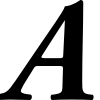

9 AGaramondPro-BoldItalic capJ


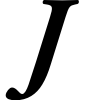

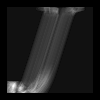



35 AJensonPro-Capt capA


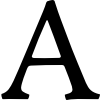

35 AJensonPro-Capt capJ


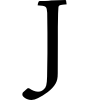

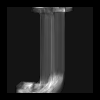



61 AJensonPro-Disp capA


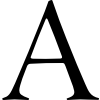

61 AJensonPro-Disp capJ


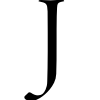

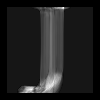



87 AJensonPro-ItDisp capA


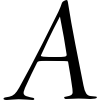

87 AJensonPro-ItDisp capJ


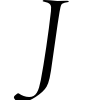

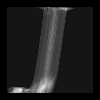



113 AJensonPro-LtSubh capA


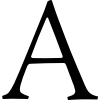

113 AJensonPro-LtSubh capJ


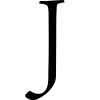

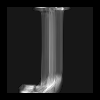



139 AJensonPro-SemiboldDisp capA


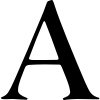

139 AJensonPro-SemiboldDisp capJ


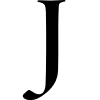

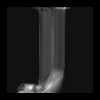



165 AJensonPro-SemiboldItDisp capA


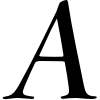

165 AJensonPro-SemiboldItDisp capJ


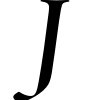

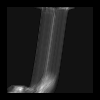



191 AvenirLTStd-BookOblique capA


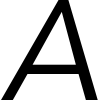

191 AvenirLTStd-BookOblique capJ


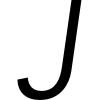

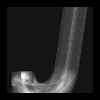



217 AvenirLTStd-Oblique capA


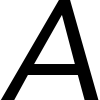

217 AvenirLTStd-Oblique capJ


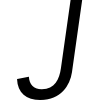

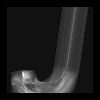



243 BauerBodoniStd-Black capA


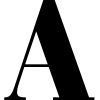

243 BauerBodoniStd-Black capJ


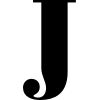

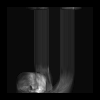



269 BauerBodoniStd-Bold capA


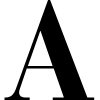

269 BauerBodoniStd-Bold capJ


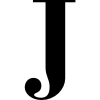

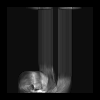



295 BauerBodoniStd-BoldItalic capA


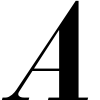

295 BauerBodoniStd-BoldItalic capJ


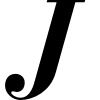

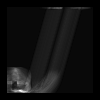



321 BellGothicStd-Bold capA


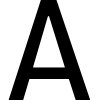

321 BellGothicStd-Bold capJ


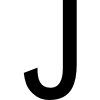

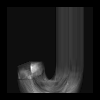



347 BellMTStd-SemiBold capA


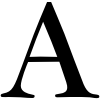

347 BellMTStd-SemiBold capJ


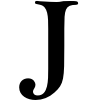

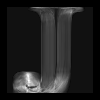



373 BemboStd-ExtraBold capA


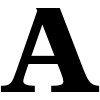

373 BemboStd-ExtraBold capJ


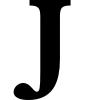

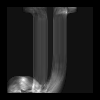



399 BenguiatGothicStd-HeavyObl capA


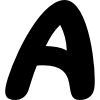

399 BenguiatGothicStd-HeavyObl capJ


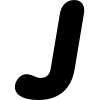

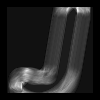



425 BernhardModernStd-BoldIt capA


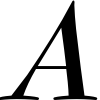

425 BernhardModernStd-BoldIt capJ


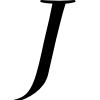

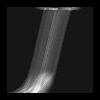



451 BickhamScriptStd-Bold capA


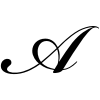

451 BickhamScriptStd-Bold capJ


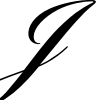

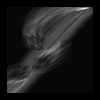



477 BodoniStd-BoldCondensed capA


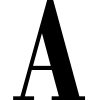

477 BodoniStd-BoldCondensed capJ


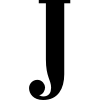

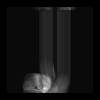



503 BulmerMTStd-Italic capA


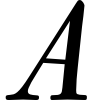

503 BulmerMTStd-Italic capJ


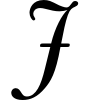

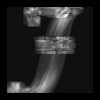



529 CalvertMTStd-Bold capA


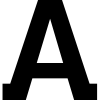

529 CalvertMTStd-Bold capJ


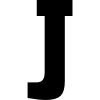

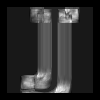



555 CentennialLTStd-Bold capA


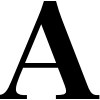

555 CentennialLTStd-Bold capJ


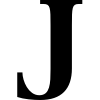

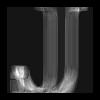



581 CerigoStd-Bold capA


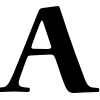

581 CerigoStd-Bold capJ


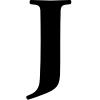

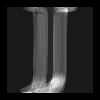



607 CerigoStd-BookItalic capA


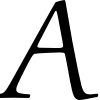

607 CerigoStd-BookItalic capJ


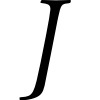

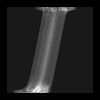



633 CerigoStd-Medium capA


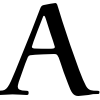

633 CerigoStd-Medium capJ


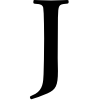

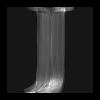



659 ChaparralPro-Light capA


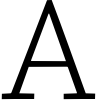

659 ChaparralPro-Light capJ


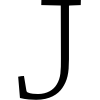

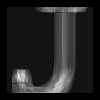



685 ChaparralPro-SemiboldIt capA


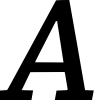

685 ChaparralPro-SemiboldIt capJ


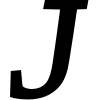

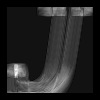



711 CheltenhamStd-Bold capA


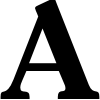

711 CheltenhamStd-Bold capJ


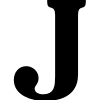

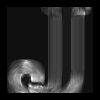



737 CheltenhamStd-Book capA


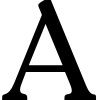

737 CheltenhamStd-Book capJ


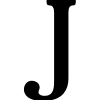

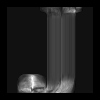



763 CheltenhamStd-BookCondIt capA


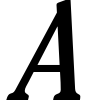

763 CheltenhamStd-BookCondIt capJ


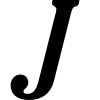

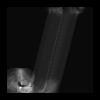



789 CronosPro-BoldIt capA


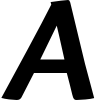

789 CronosPro-BoldIt capJ


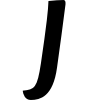

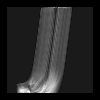



815 DanteMTStd-Bold capA


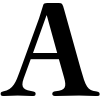

815 DanteMTStd-Bold capJ


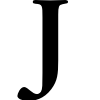

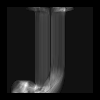



841 DomCasualStd capA


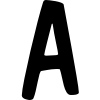

841 DomCasualStd capJ


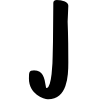

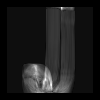



867 EhrhardtMTStd-Italic capA


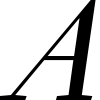

867 EhrhardtMTStd-Italic capJ


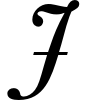

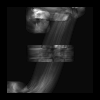



893 EhrhardtMTStd-Semibold capA


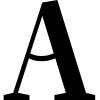

893 EhrhardtMTStd-Semibold capJ


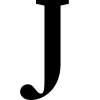

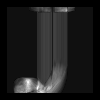



919 ElectraLTStd-Bold capA


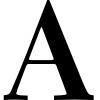

919 ElectraLTStd-Bold capJ


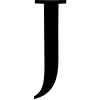

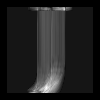



945 FeniceStd-Regular capA


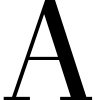

945 FeniceStd-Regular capJ


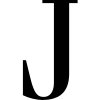

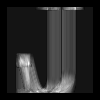



971 FetteFrakturLTStd capA


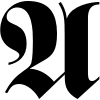

971 FetteFrakturLTStd capJ


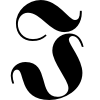

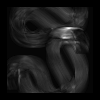



997 FolioStd-Bold capA


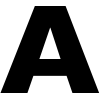

997 FolioStd-Bold capJ


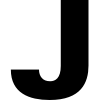

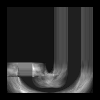



1023 FrutigerLTStd-Roman capA


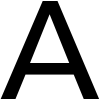

1023 FrutigerLTStd-Roman capJ


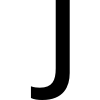

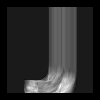

In [63]:
print('元の文字画像')
print('定数(3)で正規化')
print('最大値で正規化')
print('色相')
print('='*120)

with torch.no_grad():
    for i in range(characters['j'], 26 * 40, 26):
        pl.seed_everything(0)
        image, t = dataset[i - characters['j']]

        font = t['font']
        class_ = t['alphabet']
        print(i, dataset.unique_font[font], dataset.unique_alphabet[class_])
        display(to_pil_image(image.expand(3, -1, -1)))
        
        pl.seed_everything(0)
        image, t = dataset[i]

        font = t['font']
        class_ = t['alphabet']
        print(i, dataset.unique_font[font], dataset.unique_alphabet[class_])
        display(to_pil_image(image.expand(3, -1, -1)))
        print()

        x_batch = image[None]

        patch_batch = image.unfold(1, patch_size, 1).unfold(2, patch_size, 1).reshape(1, -1, *[patch_size]*2)
        patched_locate_list = torch.stack(torch.meshgrid([torch.arange(patch_size // 2, i - patch_size // 2) for i in image.shape[1:3]])).reshape(2, -1).T
        latent_batch = encoder(patch_batch)
        
        norm_batch = latent_batch.norm(dim=-1)
        
        norm = norm_batch[0].clone()
#         print(f'norm.max={norm.max()}')
        norm = norm / norm.max()

        feature_map = torch.zeros_like(image).repeat(1, 1, 1)
        feature_map[:, patched_locate_list[:, 0], patched_locate_list[:, 1]] = norm
        display(to_pil_image(feature_map))
        
        print()
        print('='*120)
        print()

# エントロピーとノルムの散布図
2020年9月12日